In [2]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../')
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from src.utils.graphs import get_keypoints, relative_neighborhood, random_graph
from src.utils.keypoints_filter import mean_distance_filter
from scipy.spatial.distance import cdist
from src.utils.visualize import plot_voronoi
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from shapely.geometry import Polygon, Point
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120
JSON_EXT = ".json"
JPG_EXT = ".jpg"
color = {
        1:"brown",
        2:"blue",
        3:"green",
        4:"red"
}
WRONG_CLASS = 3


#train_set = r"../test_images/dots"
JSON_EXT = ".json"
JPG_EXT = ".jpg"
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120

ModuleNotFoundError: No module named 'shapely'

In [1]:
def filter_polygons(polygon,img_shape):
    x = img_shape[0]
    y = img_shape[1]
    (miny, minx, maxy, maxx)=[int(item) for item in list(polygon.bounds)]
    if minx <= -1 or maxx > x:
        return False
    if miny <= -1 or maxy > y:
        return False
    return True

def get_label(polygon,points_df):
    x = points_df.x
    y = points_df.y
    labels = points_df.label_id
    possible_labels = []
    for idx , xs in enumerate(x):
        p = Point(x[idx],y[idx])
        if polygon.contains(p):
            possible_labels.append(labels[idx])
    
    unique_labels, unique_counts = np.unique(possible_labels,return_counts=True)
    if len(unique_labels)>=1:
        #print("possible_labels for region",unique_labels,unique_counts)
        idx = np.argmax(unique_counts)
        return unique_labels[idx]
    elif len(unique_labels)>=0:
        return WRONG_CLASS
        
def preprocess_keypoints(keys,radius=FILTER_RADIUS):
    keys = mean_distance_filter(keys,plot_filter=False,min_distance=radius)
    return keys

def walls(max_x,max_y):
    STEP = 100
    points = []
    for i in range(0,max_x,STEP):
        points.extend([[i,max_y],[i,0]])
    for i in range(0,max_y,STEP):
        points.extend([[max_x,i],[0,i]])
    return points

def get_regions(image_name,plot=False):
    json_path = image_name+JSON_EXT

    json_df = pd.read_json(json_path)
    if json_df.empty:
        return (False, False)
    
    cell_points = list(zip(json_df.x,json_df.y))
    radius = cdist(cell_points,cell_points)
    radius = radius[radius>0].min()*0.5
    print(radius)
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    labels = json_df.label_id
    sift = cv.SIFT_create(sigma = 0.45,edgeThreshold = 10)
    keys = get_keypoints(img_arr,detector=sift)
    max_x = img_arr.shape[0]-1
    max_y = img_arr.shape[0]-1
    wall = walls(max_x,max_y)
    keys = preprocess_keypoints(keys,radius)
    keys.extend(wall)
    vor = Voronoi(keys)
    polygons = []
    
    tmp_df = json_df.copy()
    labels_list = []
    if plot:
        plot_voronoi(vor,img_arr,points_size=5,show_points=True,show_verticles=False,line_width=0.3)
    for idx ,region in enumerate(vor.regions):
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            x = Polygon(polygon)
            if x.is_empty:
                continue
            
            if filter_polygons(x,img_arr.shape):
                label = get_label(x,tmp_df)

                polygons.append(x)
                #print(label)
                labels_list.append(label)
                if plot:
                    plt.fill(*zip(*polygon),color[label],alpha=0.5)
        else:
            #print(region,[vor.vertices[v] for v in region if v!=-1])
            pass
    if plot:
        plot_labels(json_df)
        plt.show()
    return polygons,labels_list

def plot_labels(df):
    for idx , row in df.iterrows():
            x = row[0]; y = row[1]; label = row[2]
            plt.plot(x, y, marker='^', color=color[label])
            
def plot(image_name):
    json_path = image_name+JSON_EXT

    json_df = pd.read_json(json_path)
    cell_points = list(zip(json_df.x,json_df.y))
    vor = Voronoi(cell_points)
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    plot_voronoi(vor,img_arr,show_points=True,show_verticles=False,line_width=0.3)
    #plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()

def plot_arr(img_arr):
    fig, ax = plt.subplots()
    ax.imshow(img_arr)
   # ax.set_ylim([0, 180])
   # ax.set_xlim([0, 180])
   # plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    return fig

            
def get_pixels(image_name,polygon,plot=False):
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    
    #plot_arr(img_arr)
    #print(img_arr.shape)
    
    (miny, minx, maxy, maxx)=[int(item) for item in list(polygon.bounds)]
   # print(polygon.bounds)
    shape = img_arr.shape
    x_range = range(minx,maxx)
    y_range = range(miny,maxy)
    if plot:
        test = np.copy(img_arr)
    mask = np.copy(img_arr[minx:maxx,miny:maxy])
    for x in x_range:
        for y in y_range:
            p = Point(y,x)
            if not polygon.contains(p):
                if plot:
                    test[x,y]=test[x,y]*[255,0,0]
                mask[x-minx,y-miny]=mask[x-minx,y-miny]*[0,0,0]
    #
    if plot:
        plot_arr(test)
        plot_arr(mask)
    return mask

In [115]:

OCTAVE = 30

In [116]:
FILTER_RADIUS

3

In [117]:
train_set = r"../data/Ki67/SHIDC-B-Ki-67/Train/p20_0143_1"

12.747548783981962


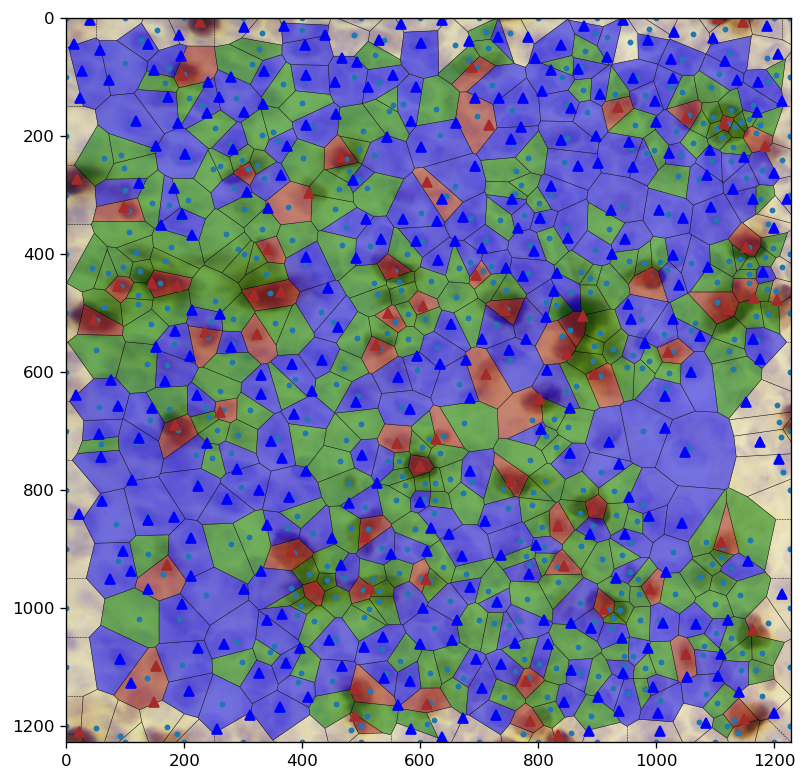

In [118]:
polygons,labels = get_regions(train_set,True)

In [59]:
def create_set(path,prefix,distpath):
    if not os.path.exists(distpath):
        os.mkdir(distpath)
    print('Working at: ',path)
    filelist = []
    for root, dirs, files in os.walk(path, topdown=False):
        for file in files:
            filename = file.split('.')[0]
            ext = file.split('.')[1]
            if ext == 'jpg':
                filepath = os.path.join(root,filename)
                if os.path.exists(filepath+'.json') and os.path.getsize(filepath+'.json') > 1:
                    filelist.append((filename,filepath))
    df = pd.DataFrame(columns=['filename','label'])
    for filename, filepath in tqdm(filelist):
        try:
            polygons,labels = get_regions(filepath,False)
            if polygons is False:
                continue
            it = 0
            for idx, polygon in enumerate(polygons):
                arr = get_pixels(filepath,polygon,False)
                im = Image.fromarray(arr)
                f = filename+"_"+str(it)+prefix+".jpg"
                dist = os.path.join(distpath,f)
                it +=1
                l = labels[idx]
                df_tmp = pd.DataFrame({
                    'filename':[f],
                    'label':[l]
                })
                df=df.append(df_tmp)
                im.save(dist)
                #plt.show()
            #break

            df.to_csv(os.path.join(distpath,"labels.csv"))
        except Exception as e:
            print("Error with file: ", filename," : ", e)

In [60]:
train_path = r"../data/Ki67/SHIDC-B-Ki-67/Train/"
data_type = "Train"
prefix = str(FILTER_RADIUS)+"_"+str(OCTAVE)+data_type
create_set(train_path,prefix,r"../dl/train_mean_distance_"+prefix)

Working at:  ../data/Ki67/SHIDC-B-Ki-67/Train/


  0%|                                                                                         | 0/1656 [00:51<?, ?it/s]


KeyboardInterrupt: 